In [1]:
import pandas as pd
from datetime import datetime
from ast import literal_eval
# network
import networkx as nx
import community as community_louvain
import community.community_louvain as community_louvain
import yfinance as yf
# from networkx.algorithms import community

# visualization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import operator
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer

sns.set(rc = {'figure.figsize':(15,8)})

In [2]:
df = pd.read_csv("verified_nft_tweets.csv")
df.head()

C:\Users\huoda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id        date      time       username  \
0  1.36574E+18  28/02/2021   0:52:48  davidzhorvath   
1  1.36567E+18  27/02/2021  20:07:42    starkillers   
2  1.36566E+18  27/02/2021  19:10:44             tj   
3  1.36565E+18  27/02/2021  18:40:02  john_dahlback   
4  1.36545E+18  27/02/2021   5:12:26       teedubya   

                                               tweet language  \
0  My work, one of many, from a solo show in Toky...       en   
1  #nftart article from @Forbes #zil @zilliqa get...       en   
2  More colors and info coming soon. But in the m...       en   
3  The auction has started!  https://t.co/MKFCF29...       en   
4  Here's some art I began in Nov 2008. I create ...       en   

                              mentioned_user                         forum  \
0                                         []                            []   
1      ['forbes', 'zilliqa', 'mintable_app']  ['www.forbes.com', 'bit.ly']   
2                                         []       ['www.colorblocks.org']   
3                              ['heartaake']            ['foundation.app']   
4  ['rariblecom', 'opensea', 'niftygateway']                            []   

  replies_count retweets_count  likes_count  \
0             1              0          9.0   
1             1             15         56.0   
2             1              1          1.0   
3             3              3         11.0   
4            10             12        144.0   

                                       hashtags cashtags quoted_user  video  \
0                                    ['nftart']       []        none    1.0   
1                      ['nftart', 'zil', 'nft']       []        none    0.0   
2                    ['nftart', 'nftcommunity']       []        none    0.0   
3  ['nftart', 'nft', 'cryptopunk', 'cryptoart']       []        none    0.0   
4                  ['nft', 'bitcoin', 'nftart']       []        none    1.0   

  reply_to_user  
0            []  
1            []  
2            []  
3            []  
4            []

In [3]:
globals = {

    'nan': 0

}
df['mentioned_user'] = df['mentioned_user'].astype(str)
df['mentioned_user'] = df['mentioned_user'].apply(lambda x:eval(x, globals) if x != None else '[]'  )
df.head()

id        date      time       username  \
0  1.36574E+18  28/02/2021   0:52:48  davidzhorvath   
1  1.36567E+18  27/02/2021  20:07:42    starkillers   
2  1.36566E+18  27/02/2021  19:10:44             tj   
3  1.36565E+18  27/02/2021  18:40:02  john_dahlback   
4  1.36545E+18  27/02/2021   5:12:26       teedubya   

                                               tweet language  \
0  My work, one of many, from a solo show in Toky...       en   
1  #nftart article from @Forbes #zil @zilliqa get...       en   
2  More colors and info coming soon. But in the m...       en   
3  The auction has started!  https://t.co/MKFCF29...       en   
4  Here's some art I began in Nov 2008. I create ...       en   

                        mentioned_user                         forum  \
0                                   []                            []   
1      [forbes, zilliqa, mintable_app]  ['www.forbes.com', 'bit.ly']   
2                                   []       ['www.colorblocks.org']   
3                          [heartaake]            ['foundation.app']   
4  [rariblecom, opensea, niftygateway]                            []   

  replies_count retweets_count  likes_count  \
0             1              0          9.0   
1             1             15         56.0   
2             1              1          1.0   
3             3              3         11.0   
4            10             12        144.0   

                                       hashtags cashtags quoted_user  video  \
0                                    ['nftart']       []        none    1.0   
1                      ['nftart', 'zil', 'nft']       []        none    0.0   
2                    ['nftart', 'nftcommunity']       []        none    0.0   
3  ['nftart', 'nft', 'cryptopunk', 'cryptoart']       []        none    0.0   
4                  ['nft', 'bitcoin', 'nftart']       []        none    1.0   

  reply_to_user  
0            []  
1            []  
2            []  
3            []  
4            []

In [4]:
print('Number of rows start: ', len(df))
df = df[df.language == 'en']
print('Number of rows left: ', len(df))

Number of rows start:  100323
Number of rows left:  84404


#### Preparation: Build Network

In [5]:
df_edge = df[['username','mentioned_user']]
df_edge = df_edge.rename(columns = {'username':'Source', 'mentioned_user':'Target'})
df_edge = df_edge.explode('Target')
df_edge = df_edge[~df_edge.Target.isna()]
df_edge.to_csv('edge_list.csv', index=False)
df_edge.head()

Source        Target
1    starkillers        forbes
1    starkillers       zilliqa
1    starkillers  mintable_app
3  john_dahlback     heartaake
4       teedubya    rariblecom

In [6]:
#Centrality:build directed graph to find top pagerank score
graph = nx.DiGraph()

graph.add_nodes_from(df['username'])
nx.set_node_attributes(graph, {'retweets_count': 'retweets_count'})
nx.set_node_attributes(graph, {'replies_count': 'replies_count'})
nx.set_node_attributes(graph, {'likes_count': 'likes_count'})

In [7]:
#Draw edge between user and mentioned user
for e in df.iterrows():
    for user in e[1]['mentioned_user']:
        graph.add_edge(e[1]['username'], user)

In [8]:
print("number of nodes: ",graph.number_of_nodes())
print("number of edges: ", graph.number_of_edges())

number of nodes:  27795
number of edges:  41021


In [9]:
#Top10 been mentioned users
def print_top_nodes(scores, k):
    '''
    scores: centrality scores computed by networkx (should be a dictionary)
    k: top K nodes to print
    '''
    # sort nodes by scores in descending order
    scores_sorted = sorted(scores.items(), key = operator.itemgetter(1), reverse = True)[:k]
    result=[]
    for b in scores_sorted:
        result.append(b[0])
    return result
pagerank = nx.pagerank(graph)
print('Top 10 nodes:')
a = print_top_nodes(pagerank, 10)
print(a)

Top 10 nodes:
['opensea', 'rariblecom', 'christiesinc', 'niftygateway', 'metamask', 'coin_artist', 'spatialxr', 'garyvee', 'rarible', 'frenchmontana']


In [10]:
#Read edge list, if the target is the top 10 target, save the results in txt.
edges = pd.read_csv("edge_list.csv")
for e in edges.iterrows():
    if e[1]['Target'] in a or e[1]['Source'] in a:
        with open('topTarget', 'a') as out_file:
            out_file.write( e[1]['Target']+','+e[1]['Source']+ '\n')
       

In [12]:
#ATTENTION:save the topTarget.txt as topTarget.csv
target = pd.read_csv("topTarget.csv")
target.describe()

rariblecom   teedubya
count        4972       4972
unique        130       1043
top       opensea  jayalders
freq         2962        303

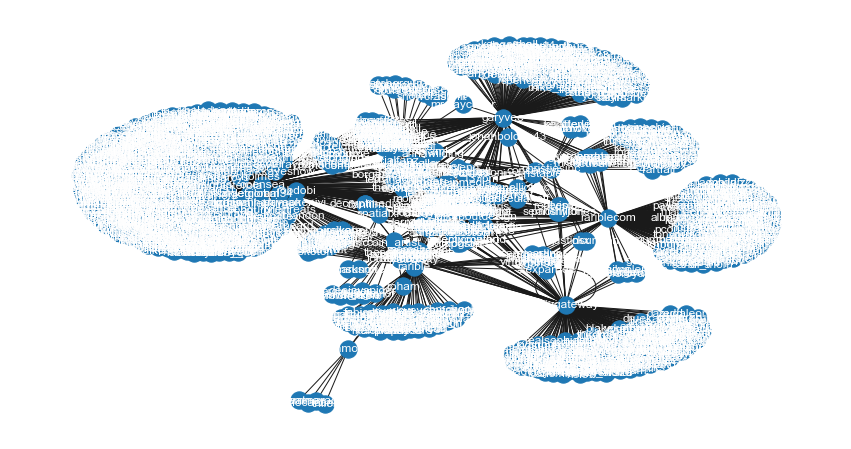

In [14]:
#Draw the nodes in top_target csv, note that it is unweighted and undirected.
dg = nx.Graph()
with open('topTarget.txt', 'r') as f:
    for line in f:
        line = line.rstrip('\n')
        if line.startswith('#'):
            continue
        parts = line.split(',')
        u = parts[0]
        v = parts[1]
        dg.add_edge(u, v)

pos = nx.spring_layout(dg, seed=92)
nx.draw_networkx(dg,pos, font_color='white')
#nx.draw_networkx_edge_labels(wg, pos, edge_labels = nx.get_edge_attributes(wg, 'weight'))
plt.axis('off')
plt.show()

#### Task 1: Community Detection

In [15]:
#determine if there exist community in network
def clustering_coefficient(g):
    ''' g: an unweighted, undirected graph '''
    
    # closed triplets
    num_closed_triplets = sum(nx.triangles(g).values())
    
    # all triplets (open and closed)
    num_triplets = 0
    for u in g.nodes():
        d = g.degree(u)
        if d > 1:
            num_triplets += d * (d - 1) / 2
    
    return float(num_closed_triplets) / num_triplets
clustering_coefficient(dg)

0.0018103626072277009

In [16]:
#Perform the community detection using modularity-based agglomerative algo
from networkx.algorithms.community import greedy_modularity_communities

communities = greedy_modularity_communities(dg)
for c in communities:
    print(sorted(c))


['0dtetrader', '0xpolygon', '4kuniverse_', '60secdocs', '9000x', '_jeffnicholas_', 'acav', 'adambhalalough', 'adambravin', 'agoracom', 'airbaltic', 'ajitpai', 'akanksharedhu', 'alexdemitchell', 'alexhofford', 'alexslemonade', 'alexvoica', 'alexyoungbased', 'allenownz', 'alliemarieevans', 'alqsyy', 'altstatemachine', 'alyssabonagura', 'am34', 'amandaoleander', 'amarigainer', 'ambushdesign', 'americancancer', 'amyhouckceo', 'andredimauro', 'andymc81', 'anggerdimas', 'angietvlau', 'animocabrands', 'annehorel', 'anshelsag', 'ant_pruitt', 'antebadzim', 'anthonyquintano', 'art3io', 'ashrafghori', 'ashwinidodani', 'associatedpress', 'baljitrihal', 'bancor', 'barnacules', 'beatsantique', 'beirutiyat', 'benliquidkenya', 'benlowy', 'bentodar', 'bernieborges', 'betootaadvocate', 'bgccan', 'bgrindia', 'birdman_bmd', 'bitfalls', 'bitgetglobal', 'blackadidanca', 'blockfoundry', 'bluethegreat', 'blueunitedefc', 'bobbibillard', 'bobbysaint', 'boyepic', 'bradygoodman', 'brandontory', 'brett_costello', 

In [17]:
#Check the number of communities
print(len(communities))

8


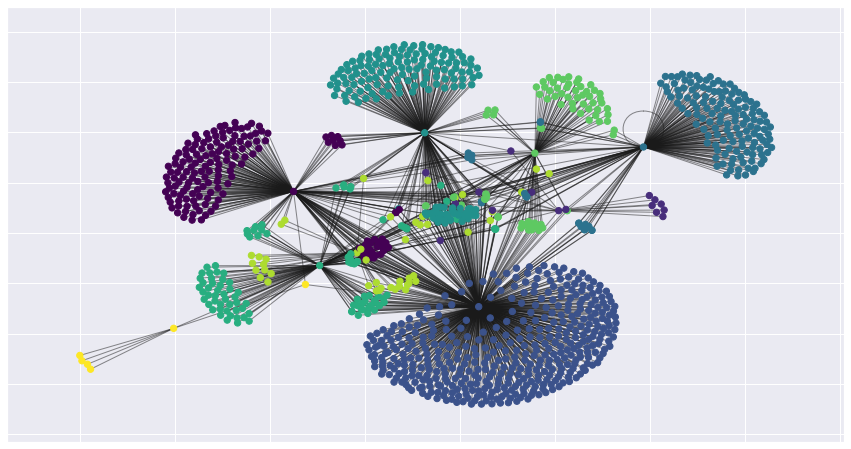

In [16]:
#Draw the graph of community
#largest_connected_graph = max((graph1.subgraph(c) for c in nx.connected_components(graph1)), key=len)
community = community_louvain.best_partition(dg)

#values = [community.get(node) for node in largest_connected_graph.nodes()]
# draw the graph
pos = nx.spring_layout(dg)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(community.values()) + 1)
nx.draw_networkx_nodes(edges, pos, community.keys(), node_size=40,
                       cmap=cmap, node_color=list(community.values()))
nx.draw_networkx_edges(dg, pos, alpha=0.5)
plt.show()

### Task 2: Sentiment Analysis in community

In [18]:
#Community sentiment analysis
sentiment = pd.read_csv('sentiment_results_verified_nft_tweets.csv')
pd.set_option('display.max_colwidth', None)
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("white")
sns.set_theme(style="ticks")


In [19]:
eth_price = yf.Ticker('ETH-USD').history(start='2020-10-02',  
                                          end='2022-03-26', 
                                          interval='1d', 
                                          actions=False).reset_index()
eth_price

Date         Open         High          Low        Close  \
0   2020-10-01   360.309143   369.264404   346.477051   353.205902   
1   2020-10-02   352.949677   354.115417   336.467163   346.238922   
2   2020-10-03   346.218628   351.307709   344.666565   346.522095   
3   2020-10-04   346.602234   354.045746   345.131012   352.579010   
4   2020-10-05   352.736816   355.214081   349.679901   353.956787   
..         ...          ...          ...          ...          ...   
536 2022-03-21  2860.103271  2954.556641  2838.250488  2897.976562   
537 2022-03-22  2897.774170  3040.382812  2892.544434  2973.131104   
538 2022-03-23  2973.145020  3036.752197  2933.306641  3031.067139   
539 2022-03-24  3031.060791  3118.387695  3012.326660  3108.062012   
540 2022-03-25  3108.448975  3183.958008  3087.490723  3106.671387   

          Volume  
0    14679481911  
1    14215390463  
2    10060167889  
3    10696959020  
4    11809507622  
..           ...  
536  15206116098  
537  16830539230  
538  16008767658  
539  18070503166  
540  17030503831  

[541 rows x 6 columns]

In [20]:
def get_community(i):
    return sentiment.loc[sentiment['username'].isin(communities[i])]

In [21]:
def draw_community_sentiment(i):
    sentiment_com = get_community(i).groupby('sentiment').agg({'sentiment':'count'})
    df = get_community(i).groupby(['date','sentiment']).size().reset_index(name="id")
    df['date'] = pd.to_datetime(df['date'])
    join_df = eth_price.merge(df, how='left', left_on='Date', right_on='date')
    join_df = join_df[['Date','Close']]
    sentiments = ['Neutral','Negative','Positive']
    plot =  sns.lineplot(data=df, x='date', y='id', hue='sentiment',hue_order = sentiments)
    sns.set_style('whitegrid',{'axes.grid': False})
    ax2 = plt.twinx()
    sns.lineplot(data=join_df,x="Date",y="Close",color="indianred")
    sns.set_style('whitegrid',{'axes.grid': False})
    dates = df['date']
    ids = df['id']
    max_index = ids.idxmax()
    max_val = ids.max()
    plot.annotate(str(max_val),(mdates.date2num(dates[max_index]),max_val))  

#### Result 2.0: Sentiment Analysis in Community 0

Text(0.5, 1.0, 'Rariblecom')

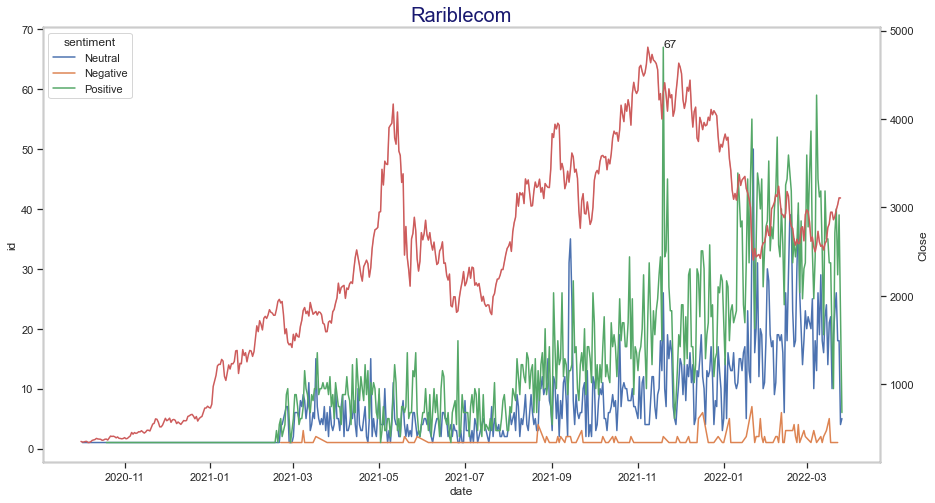

In [22]:
draw_community_sentiment(0)
plt.title('Rariblecom', fontsize=20,color='midnightblue')

#### Result 2.1: Sentiment Analysis in Community 1

Text(0.5, 1.0, 'OpenSea')

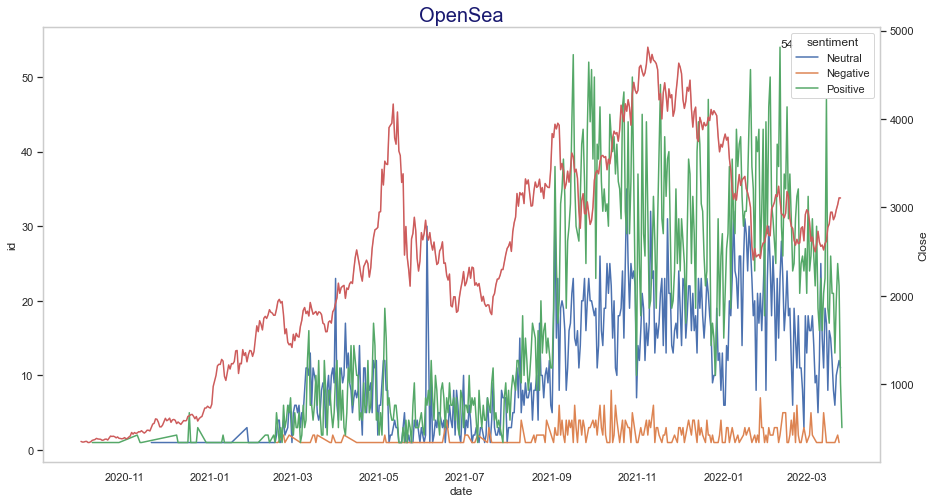

In [22]:
draw_community_sentiment(1)
plt.title('OpenSea', fontsize=20,color='midnightblue')

#### Result 2.2: Sentiment Analysis in Community 2

Text(0.5, 1.0, 'Nifty Gateway')

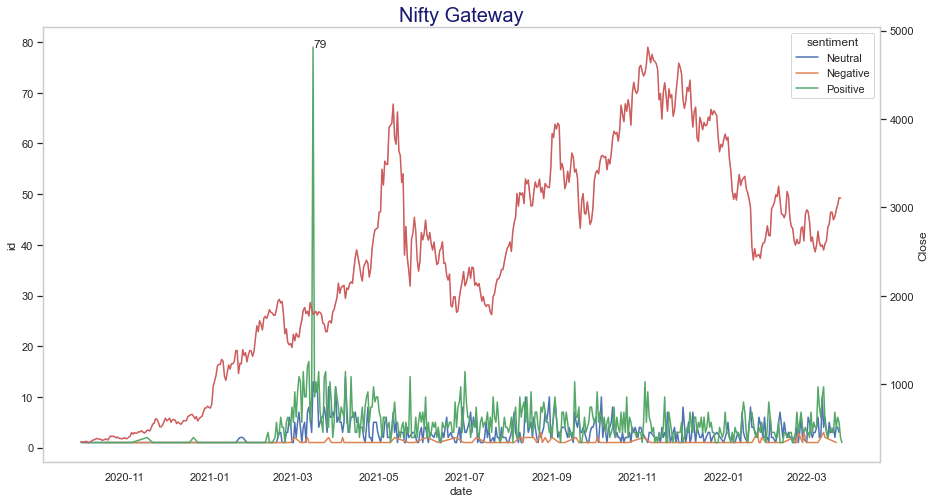

In [23]:
draw_community_sentiment(2)
plt.title('Nifty Gateway', fontsize=20,color='midnightblue')

#### Result 2.3: Sentiment Analysis in Community 3

Text(0.5, 1.0, 'Garyvee')

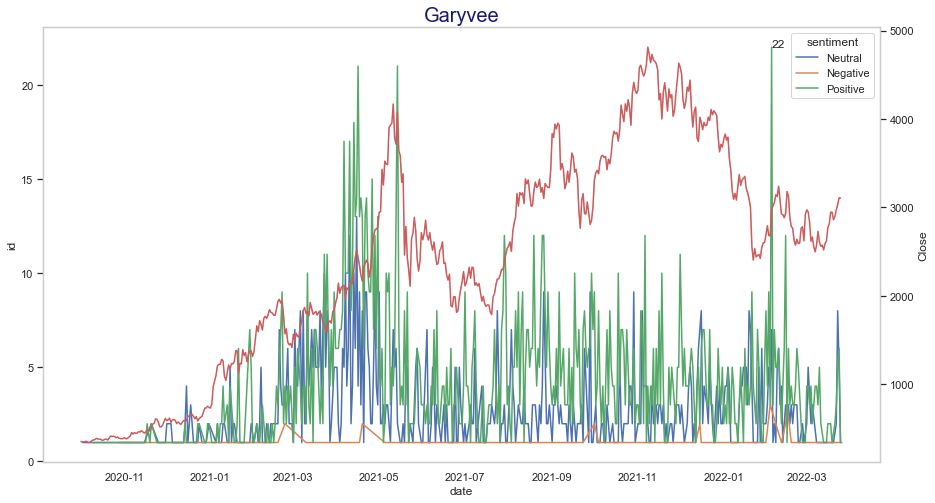

In [24]:
draw_community_sentiment(3)
plt.title('Garyvee', fontsize=20,color='midnightblue')

#### Result 2.4: Sentiment Analysis in Community 4

Text(0.5, 1.0, 'Rarible')

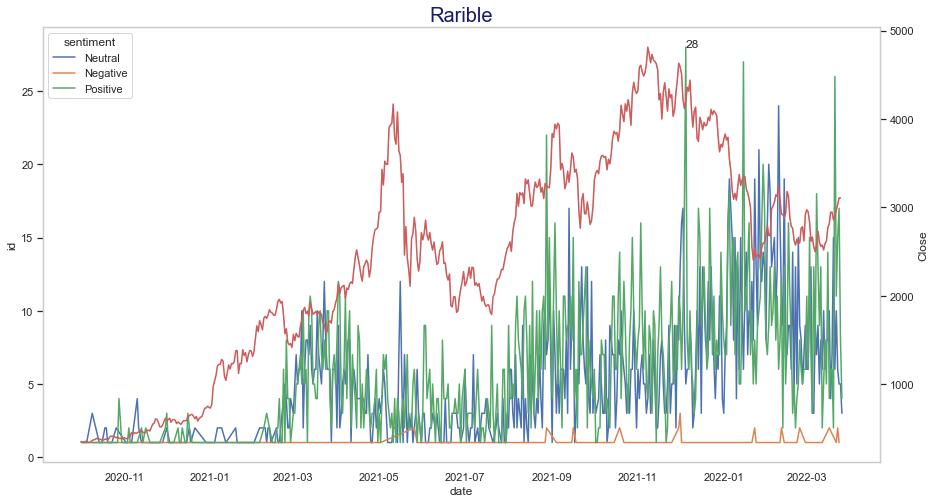

In [25]:
draw_community_sentiment(4)
plt.title('Rarible', fontsize=20,color='midnightblue')

#### Result 2.5: Sentiment Analysis in Community 5

Text(0.5, 1.0, 'Christiesinc')

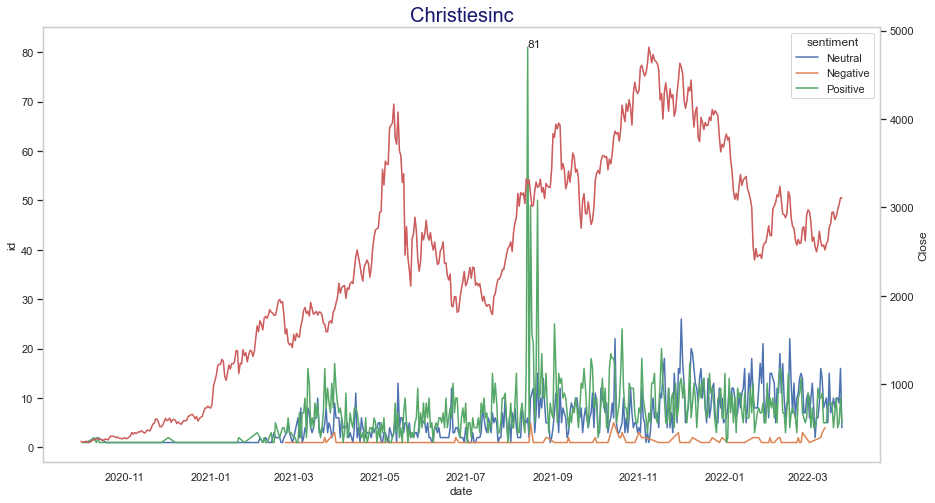

In [26]:
draw_community_sentiment(5)
plt.title('Christiesinc', fontsize=20,color='midnightblue')

#### Result 2.6: Sentiment Analysis in Community 6

Text(0.5, 1.0, 'Metamask')

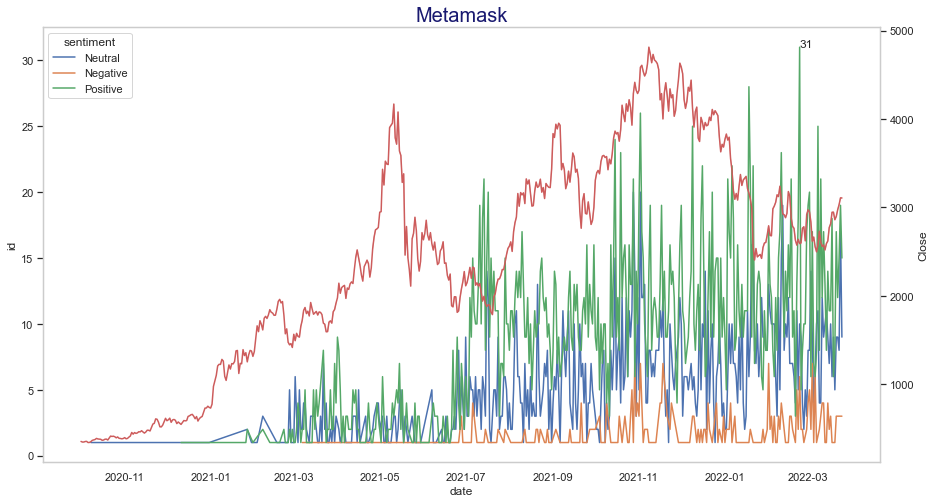

In [27]:
draw_community_sentiment(6)
plt.title('Metamask', fontsize=20,color='midnightblue')

#### Result 2.7: Sentiment Analysis in Community 7

Text(0.5, 1.0, 'Coin_artist')

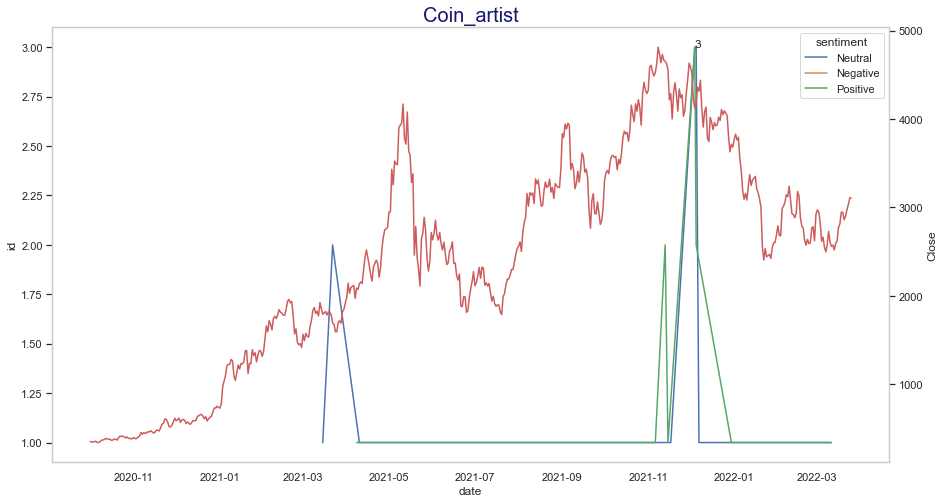

In [28]:
draw_community_sentiment(7)
plt.title('Coin_artist', fontsize=20,color='midnightblue')

### Task 3: Topic Modelling

In [29]:
from bertopic import BERTopic # https://github.com/MaartenGr/BERTopic
import re

In [30]:
# basic cleaning
def clean_com_topic(i):
    com_topic = get_community(i).copy()
    # remove words that start with http, nft, #nft
    com_topic.tweet = com_topic.apply(lambda row: re.sub(r"http\S+", "", row.tweet).lower(), 1)
    com_topic.tweet = com_topic.apply(lambda row: " ".join(filter(lambda x:x[0:3]!="nft", row.tweet.split())), 1)
    com_topic.tweet = com_topic.apply(lambda row: " ".join(filter(lambda x:x[0:4]!="#nft", row.tweet.split())), 1)
    # remove mentions
    com_topic.tweet = com_topic.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.tweet.split())), 1)
    # remove non-english words
    com_topic.tweet = com_topic.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.tweet).split()), 1)
    # remove words with less than 2 characters
    com_topic.tweet = com_topic.apply(lambda row: " ".join(re.sub(r"\b(\w{1,3})\b", "", row.tweet).split()), 1)
    return com_topic

In [31]:
#You can compare with the following original tweet before cleaning
get_community(0).tweet[0]

'My work, one of many, from a solo show in Tokyo maybe 15 years ago? All of my art is digital with the exception of the line work. I could never really hang color originals so I would include the original drawing with my 1/1 print. #nftart gives me hope.  https://t.co/qfc90NM44r'

In [32]:
com0_topic=clean_com_topic(0)
com0_topic.tweet[0]

'work many from solo show tokyo maybe years digital with exception line work could never really hang color originals would include original drawing with print gives hope'

In [33]:
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com']
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
#Define function to perform topic modelling over time, where the input i represents the community number from 0 to 7
from nltk.corpus import stopwords
def Topics_Over_Time(i, bins):
    timestamps = clean_com_topic(i).date.to_list()
    docs = clean_com_topic(i).tweet.tolist()
    classes = clean_com_topic(i)["sentiment"].tolist()
    
    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=list(stopwords.words('english')) + ['http', 'https', 'amp', 'com'])
    
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2") #all-MiniLM-L6-v2 ; all-mpnet-base-v2 ; all-MiniLM-L12-v2
    embeddings = sentence_model.encode(docs, show_progress_bar=False)
    
    model = BERTopic(language="english"
                 , embedding_model=sentence_model                 
                 , nr_topics="auto"
                 , top_n_words = 10
                 , min_topic_size=30
                 , diversity=0.2
                 , vectorizer_model=vectorizer_model
                 , verbose=True
                 )
    
    topics, probs = model.fit_transform(docs)
    
    topics_over_time = model.topics_over_time(docs, topics, timestamps, bins) #(Just add 'bins' here)
    
    result = [model,topics_over_time]
    return result
    #Visulisation 
    #model.visualize_topics_over_time(topics_over_time,  top_n_topics = 10)
    #model.visualize_barchart()

#### Result 3.1: Topic Modelling in Community 0

In [35]:
Com0_Topic = Topics_Over_Time(0,18)

Batches:   0%|          | 0/335 [00:00<?, ?it/s]

2022-07-04 11:49:15,879 - BERTopic - Transformed documents to Embeddings
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-07-04 11:49:28,526 - BERTopic - Reduced dimensionality
2022-07-04 11:49:28,974 - BERTopic - Clustered reduced embeddings
2022-07-04 11:49:54,042 - BERTopic - Reduced number of topics from 66 to 45
18it [01:27,  4.84s/it]


In [36]:
Com0_Topic[0].visualize_barchart()

In [37]:
Com0_Topic[0].visualize_topics_over_time(Com0_Topic[1],top_n_topics = 10)

In [38]:
Com0_Topic_Monthly = Topics_Over_Time(0,18)#can add bins = 18 for monthly data and bins = 72 for weekly data

Batches:   0%|          | 0/335 [00:00<?, ?it/s]

2022-07-04 11:57:04,524 - BERTopic - Transformed documents to Embeddings
2022-07-04 11:57:09,071 - BERTopic - Reduced dimensionality
2022-07-04 11:57:09,472 - BERTopic - Clustered reduced embeddings
2022-07-04 11:57:30,567 - BERTopic - Reduced number of topics from 58 to 36
18it [01:06,  3.68s/it]


In [39]:
Com0_Topic_Monthly[0].visualize_barchart()

In [40]:
Com0_Topic_Monthly[0].visualize_topics_over_time(Com0_Topic_Monthly[1],top_n_topics = 10)

In [41]:
Com0_Topic[0].visualize_heatmap()

In [42]:
Com0_Topic[0].visualize_hierarchy()

#### Result 3.2: Topic Modelling in Community 1

In [44]:
Com1_Topic = Topics_Over_Time(1,18)

Batches:   0%|          | 0/412 [00:00<?, ?it/s]

2022-07-04 12:11:08,494 - BERTopic - Transformed documents to Embeddings
2022-07-04 12:11:14,068 - BERTopic - Reduced dimensionality
2022-07-04 12:11:14,612 - BERTopic - Clustered reduced embeddings
2022-07-04 12:11:42,929 - BERTopic - Reduced number of topics from 71 to 49
18it [01:36,  5.39s/it]


In [45]:
Com1_Topic[0].visualize_barchart()

In [46]:
Com1_Topic[0].visualize_topics_over_time(Com1_Topic[1],top_n_topics = 10)

#### Result 3.3: Topic Modelling in Community 2

In [47]:
Com2_Topic_Monthly = Topics_Over_Time(2,18)

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

2022-07-04 12:15:03,345 - BERTopic - Transformed documents to Embeddings
2022-07-04 12:15:15,435 - BERTopic - Reduced dimensionality
2022-07-04 12:15:15,577 - BERTopic - Clustered reduced embeddings
2022-07-04 12:15:23,007 - BERTopic - Reduced number of topics from 23 to 14
18it [00:30,  1.69s/it]


In [50]:
Com2_Topic_Monthly[0].visualize_barchart()

In [ ]:
Com2_Topic_Monthly[0].visualize_topics_over_time(Com2_Topic_Monthly[1],top_n_topics = 10)

#### Result 3.4: Topic Modelling in Community 3

In [52]:
Com3_Topic = Topics_Over_Time(3,18)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

2022-07-04 13:42:33,877 - BERTopic - Transformed documents to Embeddings
2022-07-04 13:42:44,234 - BERTopic - Reduced dimensionality
2022-07-04 13:42:44,358 - BERTopic - Clustered reduced embeddings
2022-07-04 13:42:49,938 - BERTopic - Reduced number of topics from 18 to 9
18it [00:24,  1.38s/it]


In [53]:
Com3_Topic[0].visualize_barchart()

In [54]:
Com3_Topic[0].visualize_topics_over_time(Com3_Topic[1],top_n_topics = 10)

#### Result 3.5: Topic Modelling in Community 4

In [55]:
Com4_Topic = Topics_Over_Time(4,18)

Batches:   0%|          | 0/167 [00:00<?, ?it/s]

2022-07-04 14:11:28,171 - BERTopic - Transformed documents to Embeddings
2022-07-04 14:11:32,978 - BERTopic - Reduced dimensionality
2022-07-04 14:11:33,152 - BERTopic - Clustered reduced embeddings
2022-07-04 14:11:46,904 - BERTopic - Reduced number of topics from 38 to 21
18it [00:39,  2.21s/it]


In [56]:
Com4_Topic[0].visualize_barchart()

In [57]:
Com4_Topic[0].visualize_topics_over_time(Com4_Topic[1],top_n_topics = 10)

#### Result 3.6: Topic Modelling in Community 5

In [58]:
Com5_Topic = Topics_Over_Time(5, 18)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2022-07-04 14:17:11,715 - BERTopic - Transformed documents to Embeddings
2022-07-04 14:17:18,748 - BERTopic - Reduced dimensionality
2022-07-04 14:17:18,971 - BERTopic - Clustered reduced embeddings
2022-07-04 14:17:32,090 - BERTopic - Reduced number of topics from 39 to 21
18it [00:45,  2.50s/it]


In [59]:
Com5_Topic[0].visualize_barchart()

In [60]:
Com5_Topic[0].visualize_topics_over_time(Com5_Topic[1],top_n_topics = 10)

#### Result 3.7: Topic Modelling in Community 6

In [61]:
Com6_Topic = Topics_Over_Time(6,18)

Batches:   0%|          | 0/187 [00:00<?, ?it/s]

2022-07-04 14:23:04,582 - BERTopic - Transformed documents to Embeddings
2022-07-04 14:23:09,534 - BERTopic - Reduced dimensionality
2022-07-04 14:23:09,713 - BERTopic - Clustered reduced embeddings
2022-07-04 14:23:12,349 - BERTopic - Reduced number of topics from 5 to 5
17it [00:09,  1.75it/s]


In [62]:
Com6_Topic[0].visualize_barchart()

In [63]:
Com6_Topic[0].visualize_topics_over_time(Com6_Topic[1],top_n_topics = 10)